# Plotting a High-Latitude Cloud Field Using VIIRS NOAA-20 Data 
*This notebook will plot a high-latitude cloud field over the Norwegian Sea on 16 March 2024 using VIIRS NOAA-20 data. The spatial resolution of the cloud field is 5 km.*
***

In [1]:
!pip install xarray-datatree

  Using cached xarray_datatree-0.0.15-py3-none-any.whl.metadata (7.6 kB)
  Using cached xarray-2024.7.0-py3-none-any.whl.metadata (11 kB)
Using cached xarray_datatree-0.0.15-py3-none-any.whl (64 kB)
Using cached xarray-2024.7.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.3.1
    Uninstalling xarray-2025.3.1:
      Successfully uninstalled xarray-2025.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xmip 0.7.2 requires cf_xarray>=0.6.0, which is not installed.
xmip 0.7.2 requires xarrayutils, which is not installed.
xmip 0.7.2 requires xgcm<0.7.0, which is not installed.
herbie-data 2025.12.0 requires xarray>=2025.1.1, but you have xarray 2024.7.0 which is incompatible.


In [2]:
import earthaccess
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import matplotlib.animation as animation
import os
from PIL import Image, ImageEnhance
import scipy.stats as scipy
import pandas as pd
import matplotlib.patches as mpatches

In [3]:
# Enter your login information for NASA Earthdata
auth = earthaccess.login(persist=True)
results = earthaccess.search_datasets(instrument="VIIRS",keyword='refl') #VJ109CMG   [.A2024076.002.2024077064819] (looking for)
for item in results:
    summary = item.summary()
    print(summary["short-name"])

CLDCR_L2_VIIRS_SNPP
VNP09
VJ109
VJ109CMG_NRT
VJ109GA_NRT
VJ109_NRT
VNP09CMG_NRT
VNP09GA_NRT
VNP09_NRT


In [4]:
# Alter the time span (tspan), bbox, shortname, and scene specifications
tspan = ("2024-03-16", "2024-03-16") 
lon_min, lon_max = -6.0, 18.0 #og
lat_min, lat_max = 66.04, 81.6 #og 
bbox = (lon_min, lat_min, lon_max, lat_max)
shortname = "VJ109CMG"
clouds = (0,100) #change to (0,100) to see all satellite images (might have clear spot over spot of interest, even if cloudy)

In [5]:
# pull and stream the data
results = earthaccess.search_data(
    short_name=shortname,
    granule_name = '*A2024076.002.2024077064819*', #"*D*4km*.nc", #'*.D*4km*',   #Kd:"*4km*.nc",  #*.8D*4km*", #"*DAY*4km*.nc*" #"*AOP*.nc*"
    temporal=tspan,
    bounding_box=bbox
)
paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
paths

[<File-like object S3FileSystem, lp-prod-protected/VJ109CMG.002/VJ109CMG.A2024076.002.2024077064819/VJ109CMG.A2024076.002.2024077064819.h5>]

In [7]:
index=0
datatree = open_datatree(paths[index], engine='h5netcdf', phony_dims='access') # open the dataset based on that day
dataset = xr.merge(datatree.to_dict().values()) # merge the datatree to a dictionary format
dataset = dataset.set_coords(("lon", "lat")) # set the map based on lat and lon
dataset

<xarray.Dataset> Size: 6GB
Dimensions:             (phony_dim_0: 3600, phony_dim_1: 7200)
Coordinates:
    lat                 (phony_dim_0) float64 29kB ...
    lon                 (phony_dim_1) float64 58kB ...
Dimensions without coordinates: phony_dim_0, phony_dim_1
Data variables: (12/34)
    StructMetadata.0    |S32000 32kB ...
    BrightTemp_M12      (phony_dim_0, phony_dim_1) float64 207MB ...
    BrightTemp_M13      (phony_dim_0, phony_dim_1) float64 207MB ...
    BrightTemp_M14      (phony_dim_0, phony_dim_1) float64 207MB ...
    BrightTemp_M15      (phony_dim_0, phony_dim_1) float64 207MB ...
    BrightTemp_M16      (phony_dim_0, phony_dim_1) float64 207MB ...
    ...                  ...
    SurfReflect_QF2     (phony_dim_0, phony_dim_1) float32 104MB ...
    SurfReflect_QF3     (phony_dim_0, phony_dim_1) float32 104MB ...
    SurfReflect_QF4     (phony_dim_0, phony_dim_1) float32 104MB ...
    SurfReflect_QF5     (phony_dim_0, phony_dim_1) float32 104MB ...
    SurfReflect_QF6     (phony_dim_0, phony_dim_1) float32 104MB ...
    SurfReflect_QF7     (phony_dim_0, phony_dim_1) float32 104MB ...
Attributes: (12/41)
    AlgorithmType:                     OPS
    Conventions:                       CF-1.6
    DataResolution:                    5km
    DayNightFlag:                      Day
    EastBoundingCoord:                 180.0
    EndTime:                           2024-03-17 00:00:00
    ...                                ...
    identifier_product_doi:            10.5067/VIIRS/VJ109CMG.002
    identifier_product_doi_authority:  https://doi.org
    naming_authority:                  gov.nasa.gsfc.VIIRSland
    publisher_email:                   lpdaac@usgs.gov
    publisher_name:                    LP DAAC
    publisher_url:                     https://lpdaac.usgs.gov

In [8]:
# slice the dataset based on lon and lat. apply this slice to the variable of interest
    # we have phony_dims applied because the underlying hdf5 has no dimension scale attached. These have made data analysis tricky but have been properly resolved
lat_idx = np.where((dataset['lat'].data >= lat_min) & (dataset['lat'].data <= lat_max))[0] # lat bounds
lon_idx = np.where((dataset['lon'].data >= lon_min) & (dataset['lon'].data <= lon_max))[0] # lon bounds
bt = dataset['BrightTemp_M13'].isel(phony_dim_0=lat_idx, phony_dim_1=lon_idx) # select data within these bounds

# slice the data by subsetting to specified lat-lon bounds
lat_sub, lon_sub = dataset['lat'].data[lat_idx], dataset['lon'].data[lon_idx]
# create a meshgrid for plotting (2D data)
lon2d, lat2d = np.meshgrid(lon_sub, lat_sub)  

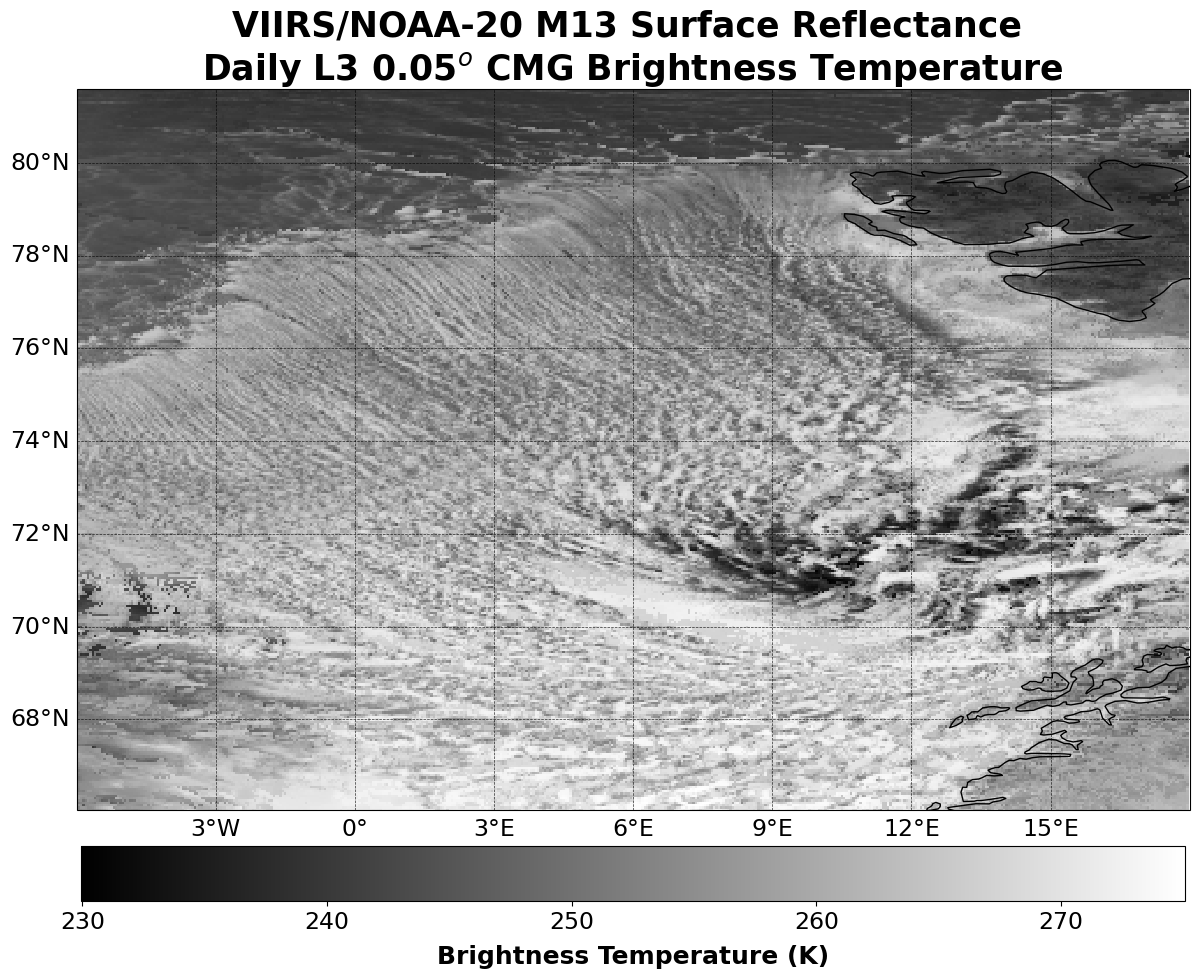

In [9]:
fig = plt.figure(figsize=(13,10))
ax = plt.axes(projection=ccrs.PlateCarree())
mesh = ax.pcolormesh(lon2d, lat2d, bt, cmap='gist_gray')
cbar = plt.colorbar(mesh, orientation='horizontal', shrink = 0.9, pad=0.04)  
cbar.set_label('Brightness Temperature (K)', fontsize = 18, fontweight='bold',labelpad=8)
cbar.ax.tick_params(labelsize=17)
ax.coastlines()
ax.set_extent([lon_min, lon_max, lat_min, lat_max])  # high-latitude example
# edit the gridlines
gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True, color = 'k', alpha=0.8, linewidth=0.5, linestyle='--')
gl.right_labels = False  
gl.top_labels = False   
gl.xlabel_style = {'size':17}
gl.ylabel_style = {'size':17}
plt.title('VIIRS/NOAA-20 M13 Surface Reflectance \nDaily L3 0.05$^o$ CMG Brightness Temperature', fontweight='bold',fontsize=25) # NOAA-20 also previously known as JPSS-1
plt.tight_layout()
plt.savefig('/home/jovyan/Desktop/VIIRS_M13_BTemp_03162023.png',dpi=900)